In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import random
from astropy.stats import *
from scipy.integrate import simps
plt.style.use('classic')

In [2]:
def XT_LC(
        t: list[float],
        t_0: float,
        peak: float,
        background: float,
        t_1_offset: float,
        t_2_offset: float,
        alpha_1: float,
        alpha_2: float
) -> list[float]:
    """
    ## Generate a light curve of an X-ray transient (XT) with a given start time, peak and background.

    
    ### Args:
        t `list[float]`: List of time values, in seconds.
        t_0 `float`: Start time of the transient, in kiloseconds.
        peak `float`: Peak count rate of the transient, in counts per second.
        background `float`: Background count rate of the transient, in counts per second.
        t_1_offset `float` (optional): Time offset for the peak of the transient, in seconds.
        t_2_offset `float` (optional): Time offset for the decay of the transient, in seconds.
        alpha_1 `float` (optional): Power law index for the plateau of the transient.
        alpha_2 `float` (optional): Power law index for the decay of the transient.

    ### Returns:
        `list[float]`: The simulated light curve as the count rate as a function of time.
    """

    t_0 = t_0 * 1000.0  # convert start time to seconds
    t_1 = t_0 + t_1_offset  # peak time is t_1_offset s after the start
    t_2 = t_1 + t_2_offset  # decay time is t_2_offset s after the peak

    light_curve = []  # list to store the simulated light curve

    for t_i in t:
        if t_i < t_0:  # before the transient starts
            y = 0.0
        elif t_0 <= t_i < t_1:  # during linear rise 
            A = peak / t_1 # slope of rise
            y = A * (t_i - t_0)
        elif t_1 <= t_i < t_2:  # during plateau
            A = peak / (t_1 - t_0)**alpha_1  # slope of power law Q?
            y = A * (t_i - t_0)**alpha_1  # power law Q?
        else:  # during decay
            A = peak / (t_2 - t_1)**alpha_2  # slope of power law Q?
            y = A * (t_i - t_0)**alpha_2  # power law Q?

        light_curve.append(y + background)  # add background to the light curve

    return light_curve


def get_distributions(light_curve: list[float]) -> tuple[list[float], list[float], list[float]]:
    """
    ## Distribution of counts and spectra of CDF-S XT1.

    
    ### Args:
        light_curve `list[float]`: The simulated light curve.

    ### Returns:
        `tuple[list[float], list[float], list[float]]`: The temporal distribution, the spectrum, and the energies.
    """

    # Temporal
    temporal_dist = light_curve / sum(light_curve)

    # Spectral
    wav = []  # energy values in keV Q? 
    flux = [] # counts per second of each energy value Q?
    data = np.loadtxt('XT1_modelo.dat', float) # what are the first two columns exactly, elo ehi? Q?
    # Q? Am I correct to think that the file represents the counts per second (column 2) of each energy band (column 0 - 1) ?

    for i in range(0, len(data)):
        wav.append((data[i][0] + data[i][1]) / 2.0) # average of the two energies Q?
        flux.append(data[i][2])

    spectral_dist = flux / sum(flux)

    return temporal_dist, spectral_dist, wav


def generate_counts(
    t: list[float], 
    wav: list[float], 
    temporal_dist: list[float], 
    spectral_dist: list[float], 
    total_counts: int
) -> tuple[np.ndarray[int], np.ndarray[int]]:
    """
    ## Generate random light curve and spectrum with total_counts counts from the temporal and spectral distributions.
    
    
    ### Args:
        t `list[float]`: List of time values, in seconds.
        wav `list[float]`: List of energy values, in keV. # Q? is this correct?
        temporal_dist `list[float]`: The temporal distribution.
        spectral_dist `list[float]`: The spectral distribution.
        total_counts `int`: The total number of counts.
    
    ### Returns:
        `tuple[np.ndarray[int], np.ndarray[int]]`: The time and the energy.
    """

    time = []
    energy = []

    # Q? Why would you loop and get only the first element? The tem and spec are already lists of N_net elements randomly chosen from t and wav
    # for i in range(0, total_counts):
    #     tem = random.choices(t, weights=temporal_dist, k=total_counts) # generate random light curve with N_net total counts from t and temporal_dist
    #     spec = random.choices(wav, weights=spectral_dist, k=total_counts) # generate random spectrum with N_net total counts from wav and spectral_dist

    #     time.append(tem[0])
    #     energy.append(spec[0]*1000) # convert energy to keV

    # Q? Would this not do the same thing as the loop above?
    time = np.array(random.choices(t, weights=temporal_dist, k=total_counts)) # generate random light curve with N_net total counts from t and temporal_dist
    energy = np.array(random.choices(wav, weights=spectral_dist, k=total_counts)) * 1000 # generate random spectrum with N_net total counts from wav and spectral_dist

    return time, energy


def simulation(
    t_exp: float, 
    t_bin: float, 
    t_0: float, 
    background: float, 
    total_counts: int, 
    peak: float = 1e-1,
    t_1_offset: float = 50.0,
    t_2_offset: float = 1000.0,
    alpha_1: float = -0.1,
    alpha_2: float = -2.0
) -> tuple[np.ndarray[float], np.ndarray[float], np.ndarray[int], np.ndarray[int]]:
    """
    ## Simulate the light curve and spectrum of an X-ray transient (XT) with a given start time, peak and background.
    
    
    ### Args:
        t_exp `float`: Exposure time, in kiloseconds.
        t_bin `float`: Size of the time bins, in seconds.
        t_0 `float`: Start time of the transient, in kiloseconds.
        background `float`: Background count rate of the transient, in counts per second.
        total_counts `int`: The total number of counts.
        peak `float`: Peak count rate of the transient, in counts per second. Defaults to `1e-1`.
        t_1_offset `float`: Time offset for the peak of the transient, in seconds. Defaults to `50.0`.
        t_2_offset `float`: Time offset for the decay of the transient, in seconds. Defaults to `1000.0`.
        alpha_1 `float`: Power law index for the plateau of the transient. Defaults to `-0.1`.
        alpha_2 `float`: Power law index for the decay of the transient. Defaults to `-2.0`.
    
    ### Returns:
        `tuple[np.ndarray[float], np.ndarray[float], np.ndarray[int], np.ndarray[int]]`: The time, the light curve, the random light curve, and the random spectrum.
    """

    t_exp = t_exp*1000 # convert exposure time to seconds
    t = np.arange(0.0, t_exp, t_bin) # create time steps from 0 to T_exp with t_bin step size

    function = np.array(XT_LC(t, t_0, peak, background, t_1_offset, t_2_offset, alpha_1, alpha_2)) # simulate light curve with given start time, peak and background
    temporal_dist, spectral_dist, wave = get_distributions(function) # get temporal and spectral distributions from the light curve
    time, energy = generate_counts(t, wave, temporal_dist, spectral_dist, total_counts) # generate random light curve and spectrum with total_counts counts from the temporal and spectral distributions

    return t, function, time, energy

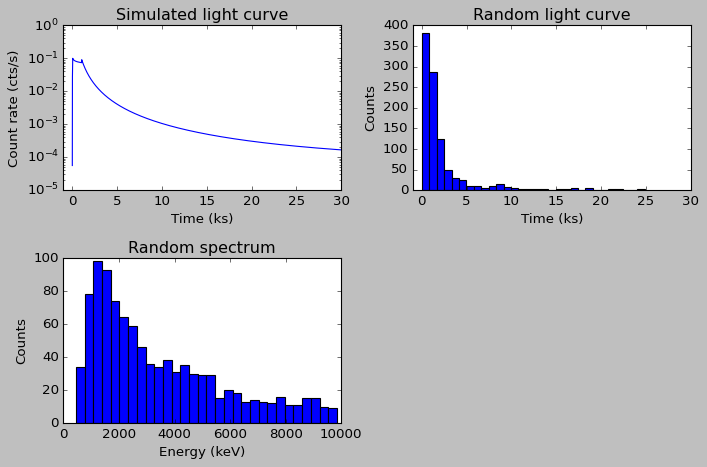

In [7]:
t, function, time, energy = simulation(
    t_exp=30, 
    t_bin=1,
    t_0=0, 
    background=5.6e-5, 
    total_counts=1000, 
    peak=1e-1
)

fig, axs = plt.subplots(2, 2, figsize=(9, 6))

# light curve
axs[0, 0].plot(t / 1000, function, label='Simulated light curve')
axs[0, 0].set_title('Simulated light curve')
axs[0, 0].set_xlabel('Time (ks)')
axs[0, 0].set_ylabel('Count rate (cts/s)')
axs[0, 0].set_yscale('log')
axs[0, 0].set_xlim(-1, 30)

# random light curve
axs[0, 1].hist(time / 1000, bins=30, label='Random light curve')
axs[0, 1].set_title('Random light curve')
axs[0, 1].set_xlabel('Time (ks)')
axs[0, 1].set_ylabel('Counts')
axs[0, 1].set_xlim(-1, 30)

# spectrum
axs[1, 0].hist(energy, bins=30, label='Random spectrum')
axs[1, 0].set_title('Random spectrum')
axs[1, 0].set_xlabel('Energy (keV)')
axs[1, 0].set_ylabel('Counts')

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

In [87]:
def get_before_after_counts(events: pd.DataFrame, t_start: float, t_end: float, background: float, theta: float) -> tuple[float, float, float, float]:
    """
    ## Get the counts before and after the mid value, as well as at the edge and center quartiles.
    
    
    ### Args:
        events `pd.DataFrame`: A DataFrame with columns for time and energy.
        t_start`float`: Lower time limit for current window.
        t_end `float`: Upper time limit for current window.
        background `float`: Background count rate of the transient, in counts per second.
        theta `float`: Instrumental off-axis angle.
    
    ### Returns:
        `tuple[float, float, float, float]`: before_counts, after_counts, edge_counts, center_counts. Being N1, N2, counts before and after mid, and N1', N2', counts at the edge and center quartiles.
    """

    # Only use 0.5-7 keV range
    counts = events # Q? This is left over from using event files right?

    # Q? Need more explanation on this
    # Appropiate aperture radius
    acis_pix_size = 0.492
    R = get_chandra_eef(theta, R0=1.32, R10=10.1, alpha=2.42)
    R /= acis_pix_size
    R_src = R*1.5
    R_bkg = R_src+20
    scl = (R_src**2)/(R_bkg**2-R_src**2)

    # Get total and background counts
    total_counts = len(counts)

    # background counts in the region corrected by aperture
    background_counts = background * abs(t_end-t_start) * scl

    # Get the time bins
    t_step = (t_end - t_start)/4
    t_q1, t_mid, t_q3 = t_start + t_step, t_start + 2*t_step, t_start+3*t_step

    # Event data before/after med_exp
    if total_counts < 5 * background_counts: # if it's less than 5 times the background it is not significant
        before_counts = -99
        after_counts = -99
        edge_counts = -99
        center_counts = -99
    else:
        before_counts = len(np.where(counts['time'] < t_mid)[0])
        after_counts = len(np.where(counts['time'] >= t_mid)[0])
        edge_counts = len(
            np.where((counts['time'] < t_q1) or (counts['time'] >= t_q3))[0])
        center_counts = len(
            np.where((counts['time'] >= t_q1) and (counts['time'] < t_q3))[0])
    return before_counts, after_counts, edge_counts, center_counts


def get_chandra_eef(theta: float, R0: float = 1.32, R10: float = 10.1, alpha: float = 2.42):
    """
    ## Calculate the Encircled Energy Fraction (EEF) radius for the off axis angle.
    Using the equation: 
        R_s = R_0 + R_10 * (theta/10)^alpha or $R_s = R_0 + R_{10} \left(\\frac{\\theta}{10}\\right)^\\alpha$.
    

    ### Args:
        theta `float`: Off axis angle, in arcmin.
        R0 `float` (optional): EEF radius at 0 arcmin off-axis. Defaults to `1.32`. From Table A1, Vito et al. 2016.
        R10 `float` (optional): EEF radius at 10 arcmin off-axis. Defaults to `10.1`. From Table A1 Vito et al. 2016.
        alpha `float` (optional): Power law index. Defaults to `2.42`. From Table A1 Vito et al. 2016.
    
    ### Returns:
        `list[float]`: The EEF radius for the off axis angle.
    """
    return R0 + R10*(theta/10)**alpha


def get_transient_candidate(before_counts: int, after_counts: int) -> bool:
    """
    ## Determine if the before and after counts indicate a transient candidate.
    
    
    ### Args:
        before_counts `int`: Counts before the mid value or of the edge quartiles.
        after_counts `int`: Counts after the mid value or of the center quartiles.  
    
    ### Returns:
        `bool`: Whether the counts indicate transient candidate. True if it is, False if it is not.
    """
    # Calculate counts upper and lower Poisson limit
    before_counts_lower_limit,  before_counts_upper_limit = poisson_conf_interval(before_counts,
                                                            interval='frequentist-confidence', sigma=5)
    after_counts_lower_limit, after_counts_upper_limit = poisson_conf_interval(after_counts,
                                                             interval='frequentist-confidence', sigma=5)

    # Select XT candidates
    is_transient_candidate = \
        ((after_counts > before_counts_upper_limit) or (after_counts < before_counts_lower_limit)) and \
        ((before_counts > after_counts_upper_limit) or (before_counts < after_counts_lower_limit)) and \
        ((before_counts > 5*after_counts) or (after_counts > 5*before_counts))

    return is_transient_candidate


def get_start_end_times(t_exp: float, window: float) -> list[tuple[float, float]]:
    """
    ## Get every start and end time for the given exposure time and window size.

    Calculated by splitting the exposure according to three passes.
    1. Split into windows of the given size plus a residual window.
    2. Backward split into windows of the given size plus a residual window.
    3. A window of half size, then split into windows of the given size plus a residual window.
    
    
    ### Args:
        t_exp `float`: Exposure time, in kiloseconds.
        window `float`: Window size, in kiloseconds.
    
    ### Returns:
        `list[tuple[float, float]]`: List of start and end times for the given exposure time and window size.
    """
    start_end_times = []

    current_start = 0.0
    current_end = window

    if t_exp < window:
        return [(0, t_exp)]

    # forward
    while current_end < t_exp:
        start_end_times.append((current_start, current_end))
        current_start += window
        current_end += window
    else: # residual window
        start_end_times.append((current_start, t_exp))

    # backward
    current_start = t_exp - window
    current_end = t_exp
    while current_start > 0:
        start_end_times.append((current_start, current_end))
        current_start -= window
        current_end -= window
    else: # residual window
        start_end_times.append((0, current_end))

    # shift
    shift = window / 2
    start_end_times.append((0, shift))

    current_start = shift
    current_end = shift + window
    while current_end < t_exp:
        start_end_times.append((current_start, current_end))
        current_start += window
        current_end += window
    else: # residual window
        start_end_times.append((current_start, t_exp))

    return start_end_times


def transient_selection(time: list[float], energy: list[float], t_exp: float, background: float, theta: float, e_lower: float, e_upper: float, window: float = 20.0) -> bool:
    '''
    Determine if there are detections
    Input:
        time: time of the events
        energy: energy of the events
        T_exp: exposure time
        bkg:background rate
        theta: instrumental off-axis angle
        Elo and Eup: the Chandra energy band used (units: eV)
    Output:
        xt_idxs: detection
    '''

    # Create a DataFrame with the time and energy
    events_total = pd.DataFrame(list(zip(time, energy)))
    events_total.columns = ['time', 'energy']

    # Select events within the energy band
    aux = (e_lower <= events_total['energy']) & (
        events_total['energy'] <= e_upper)
    events_total = events_total[aux] # selects the elements of events_total that correspond to a true value in aux

    for t_start, t_end in get_start_end_times(t_exp, window):
        # Select events within the time window
        aux = (t_start <= events_total['time']) & (
            events_total['time'] < t_end)
        events = events_total[aux]

        # Get counts
        before_counts, after_counts, edge_counts, center_counts = get_before_after_counts(
            events, t_start, t_end, background, theta)

        # Select candidate
        # By N1 and N2
        is_transient_candidate_1 = get_transient_candidate(before_counts, after_counts)
        # By N1' and N2'
        is_transient_candidate_2 = get_transient_candidate(edge_counts, center_counts)
        # Combine the results
        is_transient_candidate = is_transient_candidate_1 | is_transient_candidate_2

        if is_transient_candidate:
            return True
        
    return False
        

In [4]:
def simulation_FXRT(T_exp, F_peak, bkg, theta, N_simulations):
    # default which could be changed
    # convert F_peak to net counts: Yang et al. 2019
    N_net = int(1.6e14*F_peak)
#    bkg=2.5e-4 #background count rate
#    theta=8.0 #off-axis angle of the position of the source
#    t_bin=10 #sec for the generation of counts per bin
    # fixed
    Elo = 5e2  # ev
    Ehi = 7e3  # ev
    # Total number of simulations per bin
#    N_simulations=1000 #number of simulation per exposure
    t_bin = 2
#    t_lap=np.arange(-3.0,T_exp+t_binning,t_binning) #split bins of 1 ks
    detections = []
    for i in range(0, N_simulations):
        t_start = random.uniform(-3.0, T_exp-1.0)
        t, function, time, energy = simulation(
            T_exp, t_bin, t_start, bkg, N_net)
        events_total = pd.DataFrame(list(zip(time, energy)))
        events_total.columns = ['time', 'energy']
#        plt.hist(time,30)
        xt_idxs = transient_selection(
            time, energy, T_exp, bkg, theta, Elo, Ehi)
#        print(xt_idxs)
        detections.append(xt_idxs)
    results = pd.DataFrame(list(detections))
    results.columns = ['bol']
    P_eff = len(np.where(results['bol'] == True)[0])/N_simulations
    return P_eff
#    P_int.append(len(np.where(results['bol']==True)[0])/N_simulations)
#    medium.append(t_lap[j])
#    I1 = simps(P_int, medium)
#    P_eff=len(results[np.where(results['bol']==True)])/N_simulations/T_exp
#    return P_eff

ModuleNotFoundError: No module named 'pandas'

Exposure: 4 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 6 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 8 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 10 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 12 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 14 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 16 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 18 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 20 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 24 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 28 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 32 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 36 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 40 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 44 ksec; BKG: 0.00025 ; Fpeak= 1.2589254117941663e-13
Exposure: 50 ksec; BKG: 0.00025 ; Fpeak= 1.

Text(0, 0.5, 'Prob.')

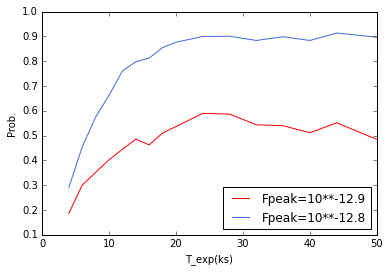

In [ ]:
t_exp = [4, 6, 8, 10, 12, 14, 16, 18, 20, 24, 28,
         32, 36, 40, 44, 50]  # Chandra exposure times

F_peak = 10**-12.9  # Peak flux (erg/cm2/s)
background = 2.5e-4  # background rate (counts/sec)
theta = 8.0  # instrumental off-axis angle (arcmin)
N_simulations = 1000  # Number simulation per exposure
prob_det = []
for i in range(0, len(t_exp)):
    print('Exposure:', t_exp[i], 'ksec; BKG:', background, '; Fpeak=', F_peak)
    P_eff = simulation_FXRT(t_exp[i], F_peak, background, theta, N_simulations)
    prob_det.append(P_eff)
plt.plot(t_exp, prob_det, color='r', label='Fpeak=10**-12.9')
# 3
F_peak = 10**-12.8  # Peak flux (erg/cm2/s)
background = 5.6e-5  # background rate (counts/sec)
theta = 5.0  # instrumental off-axis angle (arcmin)
N_simulations = 1000  # Number simulation per exposure
prob_det = []
for i in range(0, len(t_exp)):
    print('Exposure:', t_exp[i], 'ksec; BKG:', background, '; Fpeak=', F_peak)
    P_eff = simulation_FXRT(t_exp[i], F_peak, background, theta, N_simulations)
    prob_det.append(P_eff)
plt.plot(t_exp, prob_det, color='royalblue', label='Fpeak=10**-12.8')
plt.legend(loc='best')
plt.xlabel('T_exp(ks)')
plt.ylabel('Prob.')